# Quickstart Example with Off-Policy Learners
---
This notebook provides an example of implementing several off-policy learning methods with synthetic logged bandit data.

The example consists of the following four major steps:
- (1) Generating Synthetic Data
- (2) Off-Policy Learning
- (3) Evaluation of Off-Policy Learners

Please see [../examples/opl](../opl) for a more sophisticated example of the evaluation of off-policy learners with synthetic bandit data.

In [1]:
# needed when using Google Colab
# !pip install obp


In [1]:
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.linear_model import LogisticRegression
import sys
import numpy as np
import torch
#sys.path.append ('/Users/tanvikapoor/zr-obp')
#print(sys.path)

# import open bandit pipeline (obp)
import obp
from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function,
    linear_reward_function
)
from obp.policy import (
    IPWLearner, 
    QLearner,
    NNPolicyLearner, 
    Random
)

In [2]:
# obp version
print(obp.__version__)

0.5.2


## (1) Generating Synthetic Data
`obp.dataset.SyntheticBanditDataset` is an easy-to-use synthetic data generator.

It takes 
- number of actions (`n_actions`, $|\mathcal{A}|$)
- dimension of context vectors (`dim_context`, $d$)
- reward function (`reward_function`, $q(x,a)=\mathbb{E}[r|x,a]$)

as inputs and generates synthetic logged bandit data that can be used to evaluate the performance of decision making policies (obtained by `off-policy learning`).

In [3]:
# generate synthetic logged bandit data with 10 actions
# we use `logistic function` as the reward function and control the behavior policy with `beta`
# one can define their own reward function and behavior policy function such as nonlinear ones. 
dataset = SyntheticBanditDataset(
    n_actions=10,
    dim_context=5,
    beta=-2, # inverse temperature parameter to control the optimality and entropy of the behavior policy
    reward_type="binary", # "binary" or "continuous"
    reward_function=logistic_reward_function,
    random_state=12345,
)

In [5]:
# obtain training and test sets of synthetic logged bandit data
n_rounds_train, n_rounds_test = 10000, 10000
bandit_feedback_train = dataset.obtain_batch_bandit_feedback(n_rounds=int(0.8*n_rounds_train))
bandit_feedback_val = dataset.obtain_batch_bandit_feedback(n_rounds=int(0.2*n_rounds_train))
bandit_feedback_test = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds_test)

the logged bandit dataset is collected by the behavior policy as follows.

$ \mathcal{D}_b := \{(x_i,a_i,r_i)\}_{i=1}^n$  where $(x,a,r) \sim p(x)\pi_b(a | x)p(r | x,a) $

In [6]:
# `bandit_feedback` is a dictionary storing synthetic logged bandit data
bandit_feedback_train

{'n_rounds': 8000,
 'n_actions': 10,
 'context': array([[-0.20470766,  0.47894334, -0.51943872, -0.5557303 ,  1.96578057],
        [ 1.39340583,  0.09290788,  0.28174615,  0.76902257,  1.24643474],
        [ 1.00718936, -1.29622111,  0.27499163,  0.22891288,  1.35291684],
        ...,
        [-0.1733788 , -0.78463656,  0.32670987, -0.84790014, -0.46258564],
        [-0.57442296,  0.63278176,  1.29983125,  1.76094775,  2.08959885],
        [ 0.09144402,  0.06186499,  0.78168375, -0.04591524, -0.77358282]]),
 'action_context': array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]),
 'action': array([9, 2, 1, ..., 0, 6, 4]),
 'position': None,
 'rew

In [7]:
bandit_feedback_val

{'n_rounds': 2000,
 'n_actions': 10,
 'context': array([[-0.37310343, -1.03401588,  1.34262182, -1.00947787, -0.80316602],
        [-1.43759585, -0.0270564 , -0.53458309, -0.67706192,  1.31348281],
        [-0.39379578, -0.37857283, -1.09005808, -1.17700505,  0.30422047],
        ...,
        [-0.05245497,  0.9301356 ,  0.27327148,  0.03300078, -0.52283422],
        [ 1.48578475, -0.58472431, -1.54478959,  0.04898687,  0.27408695],
        [ 0.77400753, -1.95682611, -0.89318864, -0.36377085,  1.44348924]]),
 'action_context': array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]),
 'action': array([8, 3, 2, ..., 5, 9, 6]),
 'position': None,
 'rew

In [8]:
bandit_feedback_test

{'n_rounds': 10000,
 'n_actions': 10,
 'context': array([[-0.03720111,  1.36398569,  0.40713937,  0.71957237, -0.31111766],
        [ 1.28676783,  0.52924767,  0.6307793 , -1.31136174,  0.90899591],
        [-2.01267184,  0.34011559, -0.41815868,  0.82697704, -0.6559963 ],
        ...,
        [ 0.48954776,  1.54253077,  0.61630091,  0.07860084,  2.79852799],
        [-0.96639491, -0.75267869, -0.30421506,  0.44237805, -0.11708777],
        [-1.48181012, -0.63881897, -0.3122389 ,  1.3554981 ,  0.62659723]]),
 'action_context': array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]),
 'action': array([9, 4, 2, ..., 0, 2, 7]),
 'position': None,
 're

## (2) Off-Policy Learning
After generating synthetic data, we now train some decision making policies.

To train policies on logged bandit data, we use

- `obp.policy.NNPolicyLearner` (Neural Network Policy Learner)
- `obp.policy.IPWLearner`

For `NN Learner`, we use 
- Direct Method ("dm")
- InverseProbabilityWeighting ("ipw")
- DoublyRobust ("dr") 

as its objective functions (`off_policy_objective`). 

For `IPW Learner`, we use `RandomForestClassifier` and *LogisticRegression* implemented in scikit-learn for base ML methods.

A policy is trained by maximizing an OPE estimator as an objective function as follows.

$$ \hat{\pi} \in \arg \max_{\pi \in \Pi} \hat{V} (\pi; \mathcal{D}_{tr}) - \lambda \cdot \Omega (\pi)  $$

where $\hat{V}(\cdot; \mathcal{D})$ is an off-policy objective and $\mathcal{D}_{tr}$ is a training bandit dataset. $\Omega (\cdot)$ is a regularization term.

In [9]:
def graph_values (pred_actions, action, pscore, rewards):
    """Returns the numerator, denominator and ratio of the SNIPS estimator"""

    idx_tensor = torch.arange(action.shape[0], dtype=torch.long)
    iw = pred_actions[idx_tensor, action] / pscore
    num = np.mean(iw * rewards)
    den = np.mean(iw)
    ratio = num/den
    return num, den, ratio

def predict_value_den_train (l): 
    """Returns the denominator of the SNIPS estimator, after training on the 
    training data"""
    
    nn_ipw = NNPolicyLearner(
        n_actions=dataset.n_actions,
        dim_context=dataset.dim_context,
        off_policy_objective="ipw",
        batch_size=64,
        random_state=12345,
        loss_translation = l
    )

    # train NNPolicyLearner on the training set of logged bandit data
    nn_ipw.fit(
        context=bandit_feedback_train["context"],
        action=bandit_feedback_train["action"],
        reward=bandit_feedback_train["reward"],
        pscore=bandit_feedback_train["pscore"],
    )

    # obtains action choice probabilities for the train set
    action_dist_nn_ipw_train = nn_ipw.predict_proba(
        context=bandit_feedback_train["context"]
    )

    pred_actions_train = action_dist_nn_ipw_train [:,:,0]
    action_train = bandit_feedback_train["action"]
    pscore_train = bandit_feedback_train["pscore"]
    rewards_train = bandit_feedback_train["reward"]

    num_train, den_train, ratio_train = graph_values (pred_actions_train, action_train, pscore_train, rewards_train)
    return den_train


In [10]:
def nearestPoint (lo, hi, search):
  input_lo = predict_value_den_train (lo)
  input_hi = predict_value_den_train (hi)
  ans = lo + (hi - lo) * (search - input_lo) // (input_hi - input_lo)
  return ans

def interpolationSearch (lo, hi, increment, search_value, epsilon):

  while lo <= hi:

    pos = nearestPoint(lo, hi, search_value)
    input_pos = predict_value_den_train (pos)
    print(input_pos)

    if abs(input_pos - search_value) <= epsilon:
      return pos
    
    elif input_pos > search_value:
      return interpolationSearch(pos + increment, hi, increment, search_value, epsilon)

    else: 
      return interpolationSearch(lo, pos - increment, increment, search_value, epsilon)

  return -1

#print (interpolationSearch (0, 100, 0.01, 1, 0.05))

# training denominator = 1.047468440716664
# loss translation = 0.5800000000000003

In [11]:
def binarySearch (lo, hi, increment, search_value, epsilon):
  """Performs a binary search on different values of loss translation lambda, 
  to get the value of the denominator closest to 1, for the SNIPS estimator of 
  the training data"""

  while lo <= hi:

    pos = lo + ((hi - lo) / 2)
    input_pos = predict_value_den_train (pos)
    print(input_pos)

    if abs(input_pos - search_value) <= epsilon:
      return pos
    
    elif input_pos > search_value:
      return binarySearch(pos + increment, hi, increment, search_value, epsilon)

    else: 
      return binarySearch(lo, pos - increment, increment, search_value, epsilon)

  return -1

den_l = (binarySearch (0, 100, 0.01, 1, 0.05))

policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:36,  5.44it/s]

0.771697911507026
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:31,  6.31it/s]

0.7704121494847396
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:31,  6.37it/s]

0.7677255932108342
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:34,  5.85it/s]

0.7714383906473012
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:33,  5.99it/s]

0.7719953233253929
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:31,  6.25it/s]

0.8409593970288217
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning: 100%|██████████| 200/200 [00:34<00:00,  5.87it/s]

0.9745351492043558


In [12]:
def predict_value_ratio_train (l): 
    """Returns the SNIPS estimator ratio of the training data"""

    nn_ipw = NNPolicyLearner(
        n_actions=dataset.n_actions,
        dim_context=dataset.dim_context,
        off_policy_objective="ipw",
        batch_size=64,
        random_state=12345,
        loss_translation = l
    )

    # train NNPolicyLearner on the training set of logged bandit data
    nn_ipw.fit(
        context=bandit_feedback_train["context"],
        action=bandit_feedback_train["action"],
        reward=bandit_feedback_train["reward"],
        pscore=bandit_feedback_train["pscore"],
    )

    # obtains action choice probabilities for the train set
    action_dist_nn_ipw_train = nn_ipw.predict_proba(
        context=bandit_feedback_train["context"]
    )

    pred_actions_train = action_dist_nn_ipw_train [:,:,0]
    action_train = bandit_feedback_train["action"]
    pscore_train = bandit_feedback_train["pscore"]
    rewards_train = bandit_feedback_train["reward"]

    num_train, den_train, ratio_train = graph_values (pred_actions_train, action_train, pscore_train, rewards_train)
    return ratio_train

In [13]:
from bayes_opt import BayesianOptimization, UtilityFunction

def black_box_function(l):
    # l: Hyperparameter to optimize for, which is l
    f = predict_value_ratio_train (l = l)
    return f

def bayesOpt(black_box_function, pbounds, init_pnts, num_iter):
    """Function for bayes optimization"""

    # Create a BayesianOptimization optimizer,
    # and optimize the given black_box_function.
    optimizer = BayesianOptimization(f = black_box_function,
                                    pbounds = pbounds, verbose = 2,
                                    random_state = 4)
    optimizer.maximize(init_points = init_pnts, n_iter = num_iter)
    print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))
    return (optimizer.max["params"], optimizer.max["target"])
    # (init_points = 10, n_iter = 15) -> Best result: {'l': 0.8134136454425166}; f(x) = 0.858224696336694
    # (init_points = 1, n_iter = 30) -> Best result: {'l': 0.8158754544540164}; f(x) = 0.8582187948851437
    # (init_points = 15, n_iter = 20) -> Best result: {'l': 0.8152396775588937}; f(x) = 0.8582186798884766.

# Set range of C to optimize for.
# bayes_opt requires this to be a dictionary.
pbounds = {"l": [0, 1]}
init_pnts = 15
num_iter = 20
(ratio_train_l, ratio_train_val) = bayesOpt(black_box_function, pbounds, init_pnts, num_iter)


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

|   iter    |  target   |     l     |
-------------------------------------
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:35,  5.56it/s]

|  1        |  0.8492   |  0.967    |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:35,  5.58it/s]

|  2        |  0.8395   |  0.5472   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:37,  5.38it/s]

|  3        |  0.849    |  0.9727   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:35,  5.56it/s]

|  4        |  0.8526   |  0.7148   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:35,  5.58it/s]

|  5        |  0.8517   |  0.6977   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:35,  5.54it/s]

|  6        |  0.8115   |  0.2161   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:35,  5.68it/s]

|  7        |  0.8488   |  0.9763   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:35,  5.58it/s]

|  8        |  0.7963   |  0.00623  |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:35,  5.55it/s]

|  9        |  0.8146   |  0.253    |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:37,  5.37it/s]

|  10       |  0.8324   |  0.4348   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:35,  5.61it/s]

|  11       |  0.854    |  0.7794   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:35,  5.66it/s]

|  12       |  0.8101   |  0.1977   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:35,  5.63it/s]

|  13       |  0.852    |  0.863    |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:35,  5.53it/s]

|  14       |  0.8485   |  0.9834   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

|  15       |  0.8075   |  0.1638   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

|  16       |  0.8526   |  0.7148   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

|  17       |  0.854    |  0.767    |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

|  18       |  0.854    |  0.7691   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

|  19       |  0.854    |  0.7705   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

|  20       |  0.854    |  0.7709   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

|  21       |  0.854    |  0.771    |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

|  22       |  0.854    |  0.772    |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

|  23       |  0.854    |  0.7692   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

|  24       |  0.854    |  0.7743   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

|  25       |  0.854    |  0.7745   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

|  26       |  0.854    |  0.7746   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

|  27       |  0.854    |  0.7743   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

|  28       |  0.854    |  0.7744   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

|  29       |  0.854    |  0.7706   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

|  30       |  0.854    |  0.7751   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

|  31       |  0.854    |  0.7746   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

|  32       |  0.854    |  0.7709   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

|  33       |  0.854    |  0.7746   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

|  34       |  0.854    |  0.7714   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning: 100%|██████████| 200/200 [00:33<00:00,  5.94it/s]

|  35       |  0.854    |  0.7747   |
Best result: {'l': 0.7742531182900111}; f(x) = 0.8540112182111371.


In [14]:
def predict_value_ratio_val (l): 
    """Returns the SNIPS estimator ratio, after training on the 
    validation data"""

    nn_ipw = NNPolicyLearner(
        n_actions=dataset.n_actions,
        dim_context=dataset.dim_context,
        off_policy_objective="ipw",
        batch_size=64,
        random_state=12345,
        loss_translation = l
    )

    # train NNPolicyLearner on the training set of logged bandit data
    nn_ipw.fit(
        context=bandit_feedback_train["context"],
        action=bandit_feedback_train["action"],
        reward=bandit_feedback_train["reward"],
        pscore=bandit_feedback_train["pscore"],
    )

    # obtains action choice probabilities for the train set
    action_dist_nn_ipw_val = nn_ipw.predict_proba(
        context=bandit_feedback_val["context"]
    )

    pred_actions_val = action_dist_nn_ipw_val [:,:,0]
    action_val = bandit_feedback_val["action"]
    pscore_val = bandit_feedback_val["pscore"]
    rewards_val = bandit_feedback_val["reward"]

    num_val, den_val, ratio_val = graph_values (pred_actions_val, action_val, pscore_val, rewards_val)
    return ratio_val

from bayes_opt import BayesianOptimization, UtilityFunction

# Define the black box function to optimize.
def black_box_function(l):
    # l: Hyperparameter to optimize for, which is l
    f = predict_value_ratio_val (l = l)
    return f

pbounds = {"l": [0, 1]}
init_pnts = 15
num_iter = 20
(ratio_val_l, ratio_val_val) = bayesOpt(black_box_function, pbounds, init_pnts, num_iter)

# (init_points = 15, n_iter = 20) -> Best result: {'l': 0.9031853755870043}; f(x) = 0.8537869458561291.

policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

|   iter    |  target   |     l     |
-------------------------------------
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:33,  5.93it/s]

|  1        |  0.8288   |  0.967    |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:31,  6.27it/s]

|  2        |  0.8156   |  0.5472   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:32,  6.17it/s]

|  3        |  0.8293   |  0.9727   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

|  4        |  0.817    |  0.7148   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:38,  5.20it/s]

|  5        |  0.8175   |  0.6977   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:36,  5.39it/s]

|  6        |  0.7706   |  0.2161   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:38,  5.16it/s]

|  7        |  0.8295   |  0.9763   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:38,  5.22it/s]

|  8        |  0.7644   |  0.00623  |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:35,  5.55it/s]

|  9        |  0.7722   |  0.253    |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:38,  5.17it/s]

|  10       |  0.8019   |  0.4348   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:36,  5.42it/s]

|  11       |  0.8177   |  0.7794   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:36,  5.39it/s]

|  12       |  0.7697   |  0.1977   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:35,  5.54it/s]

|  13       |  0.8192   |  0.863    |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:37,  5.26it/s]

|  14       |  0.83     |  0.9834   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

|  15       |  0.7684   |  0.1638   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

|  16       |  0.8295   |  0.9763   |
[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning: 100%|██████████| 200/200 [00:34<00:00,  5.79it/s]


|  17       |  0.831    |  1.0      |
|  18       |  0.831    |  1.0      |
|  19       |  0.831    |  1.0      |
|  20       |  0.831    |  1.0      |


policy learning:   0%|          | 1/200 [00:00<00:33,  5.86it/s]

[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning: 100%|██████████| 200/200 [00:35<00:00,  5.71it/s]


|  21       |  0.831    |  1.0      |
|  22       |  0.831    |  1.0      |
|  23       |  0.831    |  1.0      |
|  24       |  0.831    |  1.0      |
|  25       |  0.831    |  1.0      |
|  26       |  0.831    |  1.0      |
|  27       |  0.831    |  1.0      |
|  28       |  0.831    |  1.0      |
|  29       |  0.831    |  1.0      |
|  30       |  0.831    |  1.0      |
|  31       |  0.831    |  1.0      |
|  32       |  0.831    |  1.0      |
|  33       |  0.831    |  1.0      |
|  34       |  0.831    |  1.0      |
|  35       |  0.831    |  1.0      |
Best result: {'l': 1.0}; f(x) = 0.8309898267969767.


In [23]:
# Policy with no loss
nn_ipw = NNPolicyLearner(
        n_actions=dataset.n_actions,
        dim_context=dataset.dim_context,
        off_policy_objective="ipw",
        batch_size=64,
        random_state=12345,
        loss_translation = 0
    )

nn_ipw.fit(
        context=bandit_feedback_train["context"],
        action=bandit_feedback_train["action"],
        reward=bandit_feedback_train["reward"],
        pscore=bandit_feedback_train["pscore"],
    )

action_dist_nn_ipw_no_loss = nn_ipw.predict_proba(
        context=bandit_feedback_test["context"]
    )

# Policy with denominator = 1 for training data
nn_ipw = NNPolicyLearner(
        n_actions=dataset.n_actions,
        dim_context=dataset.dim_context,
        off_policy_objective="ipw",
        batch_size=64,
        random_state=12345,
        loss_translation = den_l
    )

nn_ipw.fit(
        context=bandit_feedback_train["context"],
        action=bandit_feedback_train["action"],
        reward=bandit_feedback_train["reward"],
        pscore=bandit_feedback_train["pscore"],
    )

action_dist_nn_ipw_den_1 = nn_ipw.predict_proba(
        context=bandit_feedback_test["context"]
    )

# Policy with max ratio for training data
nn_ipw = NNPolicyLearner(
        n_actions=dataset.n_actions,
        dim_context=dataset.dim_context,
        off_policy_objective="ipw",
        batch_size=64,
        random_state=12345,
        loss_translation = float(ratio_train_l ["l"])
    )

nn_ipw.fit(
        context=bandit_feedback_train["context"],
        action=bandit_feedback_train["action"],
        reward=bandit_feedback_train["reward"],
        pscore=bandit_feedback_train["pscore"],
    )

action_dist_nn_ipw_max_train_ratio = nn_ipw.predict_proba(
        context=bandit_feedback_test["context"]
    )

# Policy with max ratio for validation data
nn_ipw = NNPolicyLearner(
        n_actions=dataset.n_actions,
        dim_context=dataset.dim_context,
        off_policy_objective="ipw",
        batch_size=64,
        random_state=12345,
        loss_translation = float(ratio_val_l ["l"])
    )

nn_ipw.fit(
        context=bandit_feedback_train["context"],
        action=bandit_feedback_train["action"],
        reward=bandit_feedback_train["reward"],
        pscore=bandit_feedback_train["pscore"],
    )

action_dist_nn_ipw_max_val_ratio = nn_ipw.predict_proba(
        context=bandit_feedback_test["context"]
    )

policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:36,  5.38it/s]

[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:35,  5.54it/s]

[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning:   0%|          | 1/200 [00:00<00:35,  5.61it/s]

[0 1 0 ... 0 0 0]
[-0.5  0.5 -0.5 ... -0.5 -0.5 -0.5]
Here


policy learning: 100%|██████████| 200/200 [00:34<00:00,  5.86it/s]


In [24]:
# Policy evaluation

policy_names = [
    "NN Policy Learner with no loss",
    "NN Policy Learner with training denominator = 1",
    "NN Policy Learner with max training ratio",
    "NN Policy Learner with max validation ratio"
]
action_dist_list = [
    action_dist_nn_ipw_no_loss,
    action_dist_nn_ipw_den_1,
    action_dist_nn_ipw_max_train_ratio,
    action_dist_nn_ipw_max_val_ratio
]

for name, action_dist in zip(policy_names, action_dist_list):
    true_policy_value = dataset.calc_ground_truth_policy_value(
        expected_reward=bandit_feedback_test["expected_reward"],
        action_dist=action_dist,
    )
    print(f'policy value of {name}: {true_policy_value}')

# policy value of NN Policy Learner with no loss: 0.7386491310472931
# policy value of NN Policy Learner with training denominator = 1: 0.7747569465293875
# policy value of NN Policy Learner with max training ratio: 0.7748265861941667
# policy value of NN Policy Learner with max validation ratio: 0.7680523661659651

policy value of NN Policy Learner with no loss: 0.7386491310472931
policy value of NN Policy Learner with training denominator = 1: 0.7747569465293875
policy value of NN Policy Learner with max training ratio: 0.7748265861941667
policy value of NN Policy Learner with max validation ratio: 0.7680523661659651


In [30]:
num_lst_test = []
den_lst_test = []
ratio_lst_test = []
num_lst_train = []
den_lst_train = []
ratio_lst_train = []

def graph_values (pred_actions, action, pscore, rewards):
        idx_tensor = torch.arange(action.shape[0], dtype=torch.long)
        iw = pred_actions[idx_tensor, action] / pscore
        num = np.mean(iw * rewards)
        den = np.mean(iw)
        ratio = num/den
        return num, den, ratio

for l in np.arange(0,1.1,0.1): 
    nn_ipw = NNPolicyLearner(
        n_actions=dataset.n_actions,
        dim_context=dataset.dim_context,
        off_policy_objective="ipw",
        batch_size=64,
        random_state=12345,
        loss_translation = l
    )

    # train NNPolicyLearner on the training set of logged bandit data
    nn_ipw.fit(
        context=bandit_feedback_train["context"],
        action=bandit_feedback_train["action"],
        reward=bandit_feedback_train["reward"],
        pscore=bandit_feedback_train["pscore"],
    )

    # obtains action choice probabilities for the test set
    action_dist_nn_ipw_test = nn_ipw.predict_proba(
        context=bandit_feedback_test["context"]
    )

    pred_actions_test = action_dist_nn_ipw_test [:,:,0]
    action_test = bandit_feedback_test["action"]
    pscore_test = bandit_feedback_test["pscore"]
    rewards_test = bandit_feedback_test["reward"]

    num_test, den_test, ratio_test = graph_values (pred_actions_test, action_test, pscore_test, rewards_test)
    num_lst_test.append(num_test)
    den_lst_test.append(den_test)
    ratio_lst_test.append(ratio_test)
    print(num_test, den_test, ratio_test)

    action_dist_nn_ipw_train = nn_ipw.predict_proba(
        context=bandit_feedback_train["context"]
    )

    pred_actions_train = action_dist_nn_ipw_train [:,:,0]
    action_train = bandit_feedback_train["action"]
    pscore_train = bandit_feedback_train["pscore"]
    rewards_train = bandit_feedback_train["reward"]

    num_train, den_train, ratio_train = graph_values (pred_actions_train, action_train, pscore_train, rewards_train)
    num_lst_train.append(num_train)
    den_lst_train.append(den_train)
    ratio_lst_train.append(ratio_train)


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.759777164815136 1.0001675520489501 0.7596498839206004
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7603243734333536 1.0014807907140826 0.7592001568908995
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7615320169082113 1.0027899466961656 0.7594132942967637
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7625812130850195 1.004725052161114 0.7589949224862513
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7631853254544493 1.0048485335456425 0.7595028504062435
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.764477791814735 1.0042615587789212 0.7612337494469681
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7655627040096626 1.0042769078709057 0.7623024068458134
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7650756265508437 1.0036145825411322 0.7623201574190835
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7637904429000366 1.0017843698252684 0.7624299858394249
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7707838548118421 1.0081405592263004 0.764559909585804
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning: 100%|██████████| 200/200 [00:44<00:00,  4.54it/s]

0.7571213385807956 0.9930639031228605 0.7624094846262129


In [43]:
# Numerator, Denominator, Ratio : 
# loss = 0 -> 0.7592709473199616 0.9989264890185606 0.7600869089635823
# loss = 0.1 -> 0.7605003429974979 1.0011894237360213 0.7595968604618574
# loss = 0.2 -> 0.7619300315045386 1.0027469477894313 0.7598427830513205
# loss = 0.3 -> 0.7627806003100935 1.0040469312581686 0.7597061218585223
# loss = 0.4 -> 0.7635230924156466 1.0042344528366256 0.7603036225842978
# loss = 0.5 -> 0.7645549710917013 1.004073511698654 0.7614531826442227
# loss = 0.6 -> 0.765409892936603 1.0038550432716364 0.7624705360268715
# loss = 0.7 -> 0.7648385119277056 1.003434699416066 0.7622205135748167
# loss = 0.8 -> 0.7638935402411391 1.002112866597193 0.762282938083652
# loss = 0.9 -> 0.7708756158751785 1.008204027229571 0.7646027937355659
# loss = 1 -> 0.7562755523650166 0.9921484334419409 0.7622604913474097

<ipython-input-31-4d884ad7bb8d>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


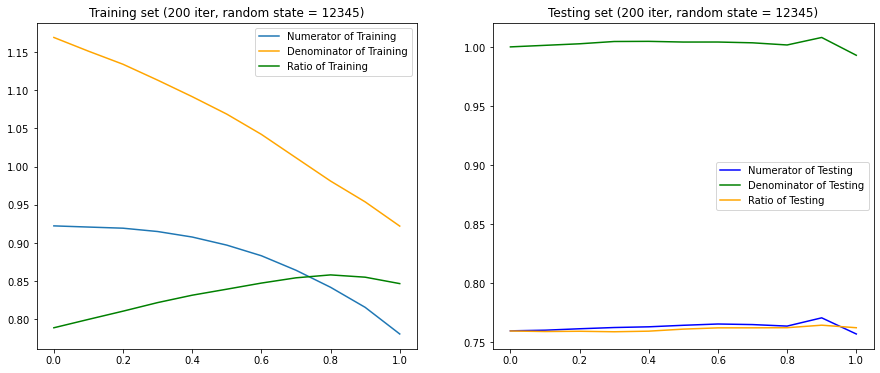

In [31]:
import matplotlib.pyplot as plt

loss = np.arange(0, 1.1, 0.1)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 6))

#loss = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
ax1.plot (loss, num_lst_train, label = "Numerator of Training")

ax1.plot (loss, den_lst_train, label = "Denominator of Training", color = "orange")

ax1.plot (loss, ratio_lst_train, label = "Ratio of Training", color = "green")
ax1.legend()
ax1.set_title ("Training set (200 iter, random state = 12345)")

ax2.plot (loss, num_lst_test, label = "Numerator of Testing", color = "blue")

ax2.plot (loss, den_lst_test, label = "Denominator of Testing", color = "green")

ax2.plot (loss, ratio_lst_test, label = "Ratio of Testing", color = "orange")
ax2.legend()
ax2.set_title ("Testing set (200 iter, random state = 12345)")
fig.show()



[0.788887819326645, 0.7998591440608702, 0.8106384500986595, 0.821858641222306, 0.8315523873944317, 0.8394219521848126, 0.8474321029410332, 0.8543105936640116, 0.8581475984551292, 0.855150431629116, 0.8467373833693137]


<ipython-input-32-c9c245ac8b4c>:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


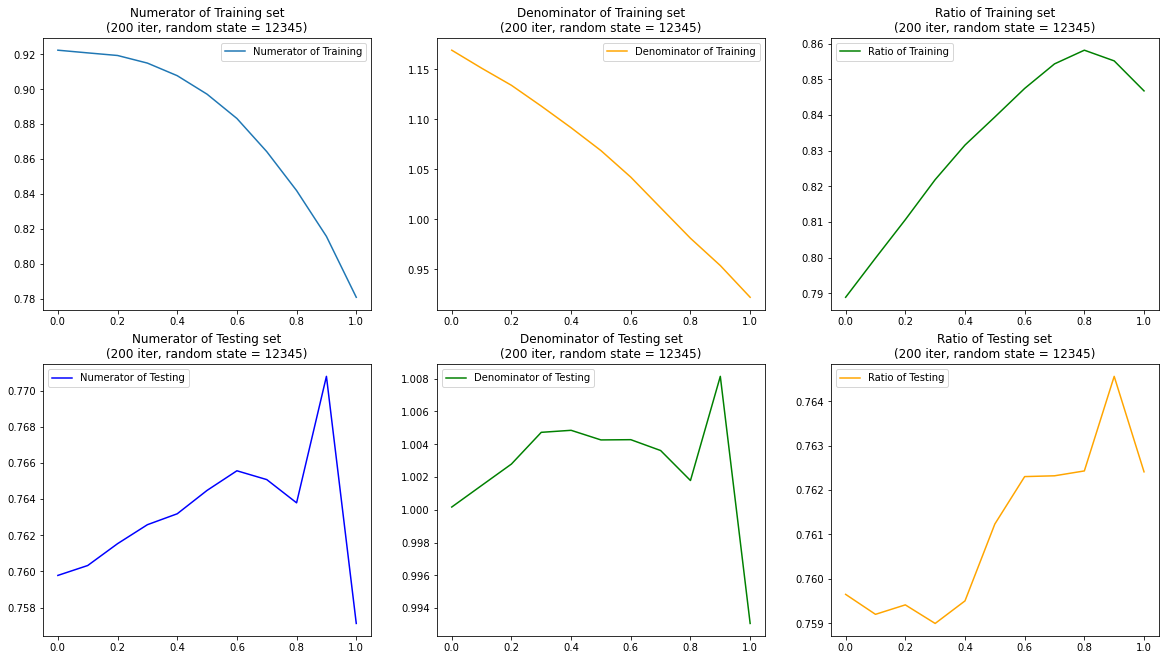

In [32]:
import matplotlib.pyplot as plt

loss = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3,figsize=(20, 11))
# ax1 = fig.add_subplot(111)
# ax2 = fig.add_subplot(121)
# ax3 = fig.add_subplot(211)
# ax4 = fig.add_subplot(221)
# ax5 = fig.add_subplot(311)
# ax6 = fig.add_subplot(321)

ax1.plot (loss, num_lst_train, label = "Numerator of Training")
ax1.legend()
ax1.set_title ("Numerator of Training set\n(200 iter, random state = 12345)")

ax2.plot (loss, den_lst_train, label = "Denominator of Training", color = "orange")
ax2.legend()
ax2.set_title ("Denominator of Training set\n(200 iter, random state = 12345)")

ax3.plot (loss, ratio_lst_train, label = "Ratio of Training", color = "green")
ax3.legend()
print(ratio_lst_train)
ax3.set_title ("Ratio of Training set\n(200 iter, random state = 12345)")

ax4.plot (loss, num_lst_test, label = "Numerator of Testing", color = "blue")
ax4.legend()
ax4.set_title ("Numerator of Testing set\n(200 iter, random state = 12345)")

ax5.plot (loss, den_lst_test, label = "Denominator of Testing", color = "green")
ax5.legend()
ax5.set_title ("Denominator of Testing set\n(200 iter, random state = 12345)")

ax6.plot (loss, ratio_lst_test, label = "Ratio of Testing", color = "orange")
ax6.legend()
ax6.set_title ("Ratio of Testing set\n(200 iter, random state = 12345)")
fig.show()

[-0.08932936  0.15603155  0.785431  ]


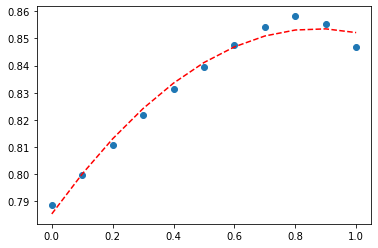

In [33]:
# x = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# # y = [0.7600869089635823, 0.7595968604618574, 0.7598427830513205, 0.7597061218585223, 0.7603036225842978, 
# #      0.7614531826442227, 0.7624705360268715, 0.7622205135748167, 0.762282938083652, 
# #      0.7646027937355659, 0.7622604913474097]
# y = ratio_lst_train

# from scipy.optimize import curve_fit, fmin
# import numpy as np
# import matplotlib.pyplot as plt

# def objective (x, a, b, c):
#     return a*(x**2) + b*x + c

# popt, _ = curve_fit(objective, x, y)
# a, b, c = popt

# plt.scatter(x,y)
# x_line = np.arange(min(x), max(x) + 0.1, 0.1)
# y_line = objective(x_line, a, b, c)
# plt.plot(x_line, y_line, '--', color='red')
# print(popt)
# plt.show()

In [34]:
# def f(x, a, b, c): 
#     return a*(x**2) + b*x + c

# max_x = fmin(lambda x: -f(x, a, b, c), 0)
# print(max_x)

Optimization terminated successfully.
         Current function value: -0.853566
         Iterations: 24
         Function evaluations: 48
[0.873375]


In [10]:
# define NNPolicyLearner with IPW as its objective function
# maximum iterations = 400

def predict_value_den_train (l): 
    nn_ipw = NNPolicyLearner(
        n_actions=dataset.n_actions,
        dim_context=dataset.dim_context,
        off_policy_objective="ipw",
        batch_size=64,
        max_iter = 400,
        random_state=12345,
        loss_translation = l
    )

    # train NNPolicyLearner on the training set of logged bandit data
    nn_ipw.fit(
        context=bandit_feedback_train["context"],
        action=bandit_feedback_train["action"],
        reward=bandit_feedback_train["reward"],
        pscore=bandit_feedback_train["pscore"],
    )

    action_dist_nn_ipw_train = nn_ipw.predict_proba(
        context=bandit_feedback_train["context"]
    )

    pred_actions_train = action_dist_nn_ipw_train [:,:,0]
    action_train = bandit_feedback_train["action"]
    pscore_train = bandit_feedback_train["pscore"]
    rewards_train = bandit_feedback_train["reward"]

    num_train, den_train, ratio_train = graph_values (pred_actions_train, action_train, pscore_train, rewards_train)

    return den_train

#print (interpolationSearch (0, 100, 0.01, 1, 0.05))

In [11]:
print (binarySearch (0, 100, 0.01, 1, 0.05))

policy learning:   0%|          | 0/400 [00:00<?, ?it/s]

[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/400 [00:00<?, ?it/s]

0.6904567946696003
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/400 [00:00<?, ?it/s]

0.6935598923592634
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/400 [00:00<?, ?it/s]

0.6930341690398185
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/400 [00:00<?, ?it/s]

0.7050762335562056
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/400 [00:00<?, ?it/s]

0.7394581647242727
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/400 [00:00<?, ?it/s]

0.7898616269822407
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning: 100%|██████████| 400/400 [01:28<00:00,  4.50it/s]

1.0044758402601124
0.7714062500000001


In [ ]:
def graph_values (pred_actions, action, pscore, rewards):
        idx_tensor = torch.arange(action.shape[0], dtype=torch.long)
        iw = pred_actions[idx_tensor, action] / pscore
        num = np.mean(iw * rewards)
        den = np.mean(iw)
        ratio = num/den
        return num, den, ratio

for l in np.arange(0,1.1,0.1): 
    nn_ipw = NNPolicyLearner(
        n_actions=dataset.n_actions,
        dim_context=dataset.dim_context,
        off_policy_objective="ipw",
        batch_size=64,
        max_iter = 400,
        random_state=12345,
        loss_translation = l
    )

    # train NNPolicyLearner on the training set of logged bandit data
    nn_ipw.fit(
        context=bandit_feedback_train["context"],
        action=bandit_feedback_train["action"],
        reward=bandit_feedback_train["reward"],
        pscore=bandit_feedback_train["pscore"],
    )

    # obtains action choice probabilities for the test set
    action_dist_nn_ipw_test = nn_ipw.predict_proba(
        context=bandit_feedback_test["context"]
    )

    pred_actions_test = action_dist_nn_ipw_test [:,:,0]
    action_test = bandit_feedback_test["action"]
    pscore_test = bandit_feedback_test["pscore"]
    rewards_test = bandit_feedback_test["reward"]

    num_test, den_test, ratio_test = graph_values (pred_actions_test, action_test, pscore_test, rewards_test)
    num_lst_test.append(num_test)
    den_lst_test.append(den_test)
    ratio_lst_test.append(ratio_test)
    print(num_test, den_test, ratio_test)

    action_dist_nn_ipw_train = nn_ipw.predict_proba(
        context=bandit_feedback_train["context"]
    )

    pred_actions_train = action_dist_nn_ipw_train [:,:,0]
    action_train = bandit_feedback_train["action"]
    pscore_train = bandit_feedback_train["pscore"]
    rewards_train = bandit_feedback_train["reward"]

    num_train, den_train, ratio_train = graph_values (pred_actions_train, action_train, pscore_train, rewards_train)
    num_lst_train.append(num_train)
    den_lst_train.append(den_train)
    ratio_lst_train.append(ratio_train)

<ipython-input-47-b20aaa20ed4a>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


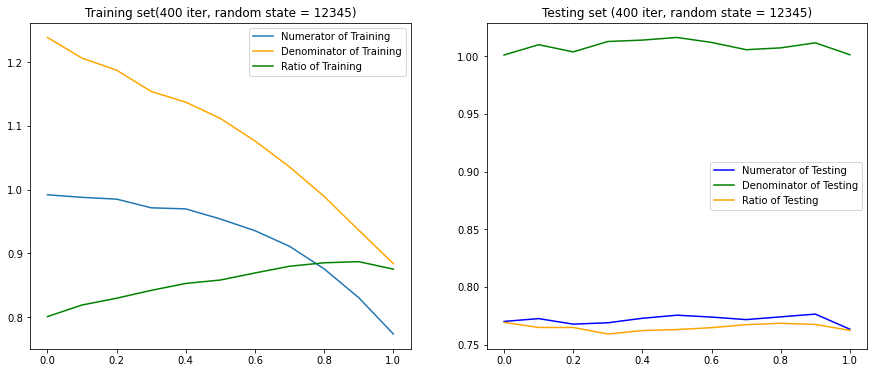

In [47]:
loss = np.arange(0, 1.1, 0.1)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 6))

#loss = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
ax1.plot (loss, num_lst_train, label = "Numerator of Training")

ax1.plot (loss, den_lst_train, label = "Denominator of Training", color = "orange")

ax1.plot (loss, ratio_lst_train, label = "Ratio of Training", color = "green")
ax1.legend()
ax1.set_title ("Training set(400 iter, random state = 12345)")

ax2.plot (loss, num_lst_test, label = "Numerator of Testing", color = "blue")

ax2.plot (loss, den_lst_test, label = "Denominator of Testing", color = "green")

ax2.plot (loss, ratio_lst_test, label = "Ratio of Testing", color = "orange")
ax2.legend()
ax2.set_title ("Testing set (400 iter, random state = 12345)")
fig.show()

<ipython-input-48-9ee98d8fc8af>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


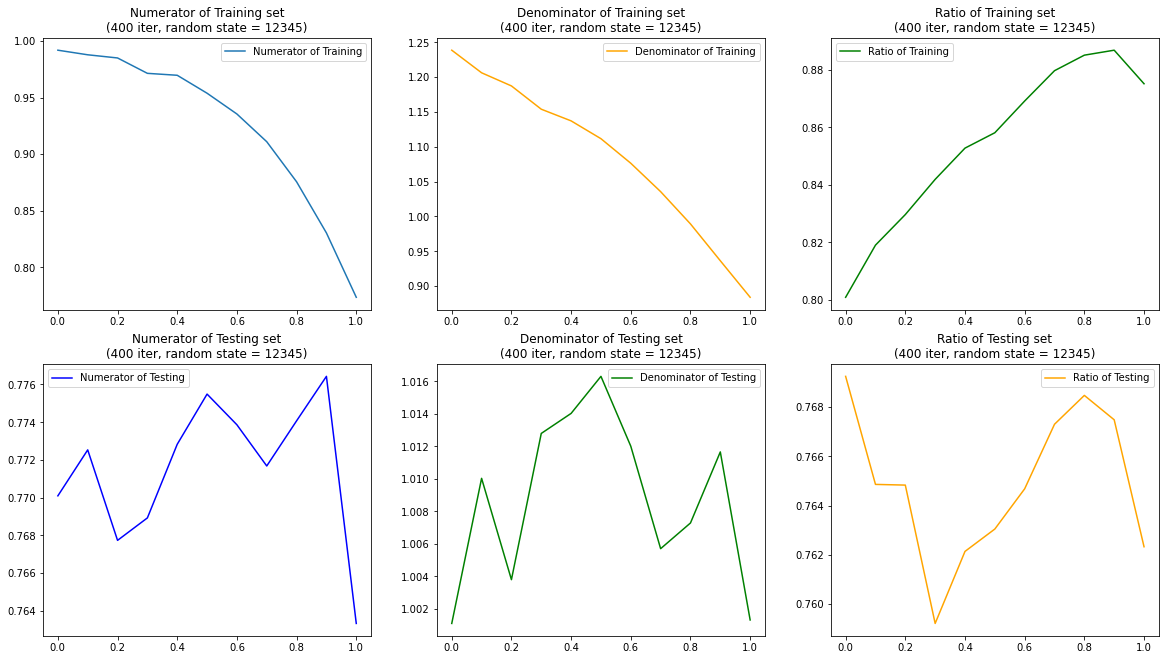

In [48]:
import matplotlib.pyplot as plt

loss = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3,figsize=(20, 11))

ax1.plot (loss, num_lst_train, label = "Numerator of Training")
ax1.legend()
ax1.set_title ("Numerator of Training set\n(400 iter, random state = 12345)")

ax2.plot (loss, den_lst_train, label = "Denominator of Training", color = "orange")
ax2.legend()
ax2.set_title ("Denominator of Training set\n(400 iter, random state = 12345)")

ax3.plot (loss, ratio_lst_train, label = "Ratio of Training", color = "green")
ax3.legend()
ax3.set_title ("Ratio of Training set\n(400 iter, random state = 12345)")

ax4.plot (loss, num_lst_test, label = "Numerator of Testing", color = "blue")
ax4.legend()
ax4.set_title ("Numerator of Testing set\n(400 iter, random state = 12345)")

ax5.plot (loss, den_lst_test, label = "Denominator of Testing", color = "green")
ax5.legend()
ax5.set_title ("Denominator of Testing set\n(400 iter, random state = 12345)")

ax6.plot (loss, ratio_lst_test, label = "Ratio of Testing", color = "orange")
ax6.legend()
ax6.set_title ("Ratio of Testing set\n(400 iter, random state = 12345)")
fig.show()

In [49]:
# define NNPolicyLearner with IPW as its objective function
# maximum iterations = 600

num_lst_test = []
den_lst_test = []
ratio_lst_test = []
num_lst_train = []
den_lst_train = []
ratio_lst_train = []

def graph_values (pred_actions, action, pscore, rewards):
        idx_tensor = torch.arange(action.shape[0], dtype=torch.long)
        iw = pred_actions[idx_tensor, action] / pscore
        num = np.mean(iw * rewards)
        den = np.mean(iw)
        ratio = num/den
        return num, den, ratio

for l in np.arange(0,1.1,0.1): 
    nn_ipw = NNPolicyLearner(
        n_actions=dataset.n_actions,
        dim_context=dataset.dim_context,
        off_policy_objective="ipw",
        batch_size=64,
        max_iter = 600,
        random_state=12345,
        loss_translation = l
    )

    # train NNPolicyLearner on the training set of logged bandit data
    nn_ipw.fit(
        context=bandit_feedback_train["context"],
        action=bandit_feedback_train["action"],
        reward=bandit_feedback_train["reward"],
        pscore=bandit_feedback_train["pscore"],
    )

    # obtains action choice probabilities for the test set
    action_dist_nn_ipw_test = nn_ipw.predict_proba(
        context=bandit_feedback_test["context"]
    )

    pred_actions_test = action_dist_nn_ipw_test [:,:,0]
    action_test = bandit_feedback_test["action"]
    pscore_test = bandit_feedback_test["pscore"]
    rewards_test = bandit_feedback_test["reward"]

    num_test, den_test, ratio_test = graph_values (pred_actions_test, action_test, pscore_test, rewards_test)
    num_lst_test.append(num_test)
    den_lst_test.append(den_test)
    ratio_lst_test.append(ratio_test)
    print(num_test, den_test, ratio_test)

    action_dist_nn_ipw_train = nn_ipw.predict_proba(
        context=bandit_feedback_train["context"]
    )

    pred_actions_train = action_dist_nn_ipw_train [:,:,0]
    action_train = bandit_feedback_train["action"]
    pscore_train = bandit_feedback_train["pscore"]
    rewards_train = bandit_feedback_train["reward"]

    num_train, den_train, ratio_train = graph_values (pred_actions_train, action_train, pscore_train, rewards_train)
    num_lst_train.append(num_train)
    den_lst_train.append(den_train)
    ratio_lst_train.append(ratio_train)

policy learning:   0%|          | 0/600 [00:00<?, ?it/s]

[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/600 [00:00<?, ?it/s]

0.7705632353665886 1.0010284292475033 0.7697715797600665
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/600 [00:00<?, ?it/s]

0.7770889246218029 1.0141096537929002 0.7662770211440061
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/600 [00:00<?, ?it/s]

0.7694203485459512 1.0072111277379294 0.7639116838134755
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/600 [00:00<?, ?it/s]

0.769646745702363 1.0156609913471721 0.7577791726366334
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/600 [00:00<?, ?it/s]

0.7758349341999883 1.0205631432543263 0.7602027756225258
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/600 [00:00<?, ?it/s]

0.7801094768159855 1.023078221854525 0.7625120544564891
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/600 [00:00<?, ?it/s]

0.7762306184467549 1.015119377271462 0.7646692948894189
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/600 [00:00<?, ?it/s]

0.7683334385975766 1.003280726535855 0.7658209893560814
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:  58%|█████▊    | 351/600 [02:05<01:29,  2.80it/s]


KeyboardInterrupt: 

<ipython-input-73-e1cdbebcf505>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


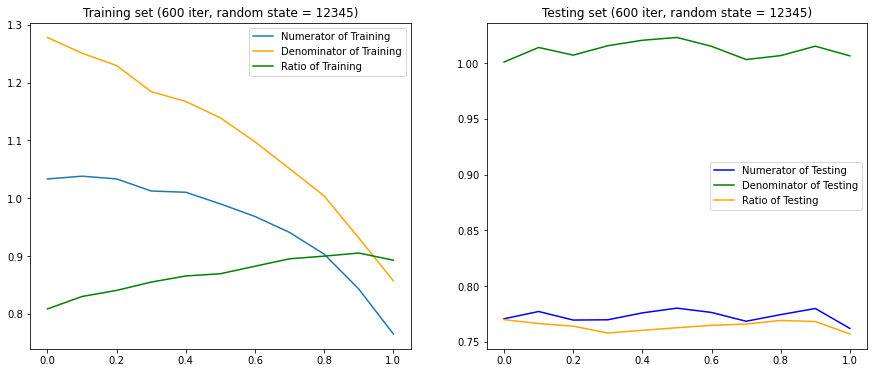

In [ ]:
loss = np.arange(0, 1.1, 0.1)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 6))

#loss = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
ax1.plot (loss, num_lst_train, label = "Numerator of Training")

ax1.plot (loss, den_lst_train, label = "Denominator of Training", color = "orange")

ax1.plot (loss, ratio_lst_train, label = "Ratio of Training", color = "green")
ax1.legend()
ax1.set_title ("Training set (600 iter, random state = 12345)")

ax2.plot (loss, num_lst_test, label = "Numerator of Testing", color = "blue")

ax2.plot (loss, den_lst_test, label = "Denominator of Testing", color = "green")

ax2.plot (loss, ratio_lst_test, label = "Ratio of Testing", color = "orange")
ax2.legend()
ax2.set_title ("Testing set (600 iter, random state = 12345)")
fig.show()

<ipython-input-74-7b9a79b6d0b5>:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 1080x864 with 0 Axes>

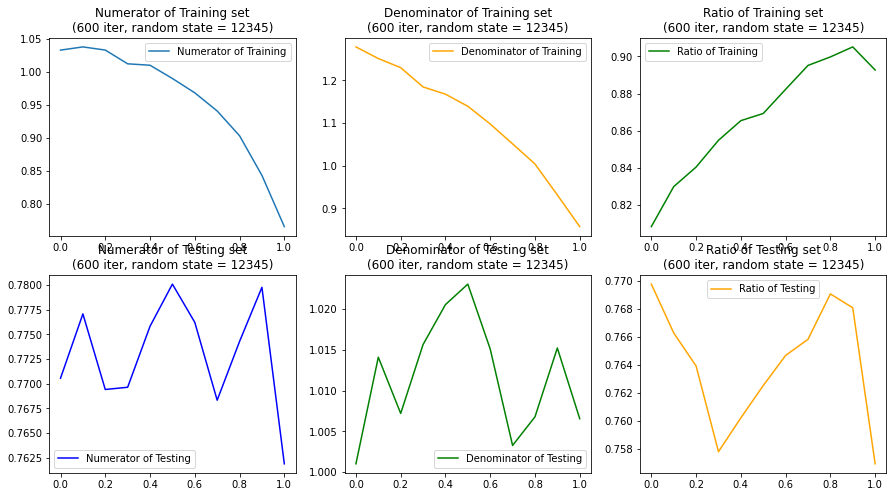

<Figure size 1080x432 with 0 Axes>

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3,figsize=(20, 11))

ax1.plot (loss, num_lst_train, label = "Numerator of Training")
ax1.legend()
ax1.set_title ("Numerator of Training set\n(600 iter, random state = 12345)")

ax2.plot (loss, den_lst_train, label = "Denominator of Training", color = "orange")
ax2.legend()
ax2.set_title ("Denominator of Training set\n(600 iter, random state = 12345)")

ax3.plot (loss, ratio_lst_train, label = "Ratio of Training", color = "green")
ax3.legend()
ax3.set_title ("Ratio of Training set\n(600 iter, random state = 12345)")

ax4.plot (loss, num_lst_test, label = "Numerator of Testing", color = "blue")
ax4.legend()
ax4.set_title ("Numerator of Testing set\n(600 iter, random state = 12345)")

ax5.plot (loss, den_lst_test, label = "Denominator of Testing", color = "green")
ax5.legend()
ax5.set_title ("Denominator of Testing set\n(600 iter, random state = 12345)")

ax6.plot (loss, ratio_lst_test, label = "Ratio of Testing", color = "orange")
ax6.legend()
ax6.set_title ("Ratio of Testing set\n(600 iter, random state = 12345)")
fig.show()

In [ ]:
# define NNPolicyLearner with IPW as its objective function
# maximum iterations = 200 and random state = 11111

num_lst_test = []
den_lst_test = []
ratio_lst_test = []
num_lst_train = []
den_lst_train = []
ratio_lst_train = []

def graph_values (pred_actions, action, pscore, rewards):
        idx_tensor = torch.arange(action.shape[0], dtype=torch.long)
        iw = pred_actions[idx_tensor, action] / pscore
        num = np.mean(iw * rewards)
        den = np.mean(iw)
        ratio = num/den
        return num, den, ratio

for l in np.arange(0,1.1,0.1): 
    nn_ipw = NNPolicyLearner(
        n_actions=dataset.n_actions,
        dim_context=dataset.dim_context,
        off_policy_objective="ipw",
        batch_size=64,
        max_iter = 200,
        random_state=11111,
        loss_translation = l
    )

    # train NNPolicyLearner on the training set of logged bandit data
    nn_ipw.fit(
        context=bandit_feedback_train["context"],
        action=bandit_feedback_train["action"],
        reward=bandit_feedback_train["reward"],
        pscore=bandit_feedback_train["pscore"],
    )

    # obtains action choice probabilities for the test set
    action_dist_nn_ipw_test = nn_ipw.predict_proba(
        context=bandit_feedback_test["context"]
    )

    pred_actions_test = action_dist_nn_ipw_test [:,:,0]
    action_test = bandit_feedback_test["action"]
    pscore_test = bandit_feedback_test["pscore"]
    rewards_test = bandit_feedback_test["reward"]

    num_test, den_test, ratio_test = graph_values (pred_actions_test, action_test, pscore_test, rewards_test)
    num_lst_test.append(num_test)
    den_lst_test.append(den_test)
    ratio_lst_test.append(ratio_test)
    print(num_test, den_test, ratio_test)

    action_dist_nn_ipw_train = nn_ipw.predict_proba(
        context=bandit_feedback_train["context"]
    )

    pred_actions_train = action_dist_nn_ipw_train [:,:,0]
    action_train = bandit_feedback_train["action"]
    pscore_train = bandit_feedback_train["pscore"]
    rewards_train = bandit_feedback_train["reward"]

    num_train, den_train, ratio_train = graph_values (pred_actions_train, action_train, pscore_train, rewards_train)
    num_lst_train.append(num_train)
    den_lst_train.append(den_train)
    ratio_lst_train.append(ratio_train)

policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7609342455154446 1.00045125230955 0.7605910270578619
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7642796855672114 0.9987787834787909 0.7652141777633594
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7677122861609816 1.0015649795244377 0.7665127094654469
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7723775322219851 1.0049490407991053 0.7685738289852128
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7667084487602261 1.0014457503495424 0.7656015800083189
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7659031673782026 1.000460472046988 0.7655506527020799
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7672463759282189 0.9999626772143154 0.7672750127690816
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7702632373671454 1.0036360105323747 0.7674726985519007
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7686937729540434 1.0011795294742651 0.7677881442079588
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7667930156767911 1.0003023020350388 0.7665612826410668
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning: 100%|██████████| 200/200 [01:05<00:00,  3.07it/s]

0.7562031522752856 0.9903275501160688 0.7635889279124435


<ipython-input-24-ac50103ff2d6>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


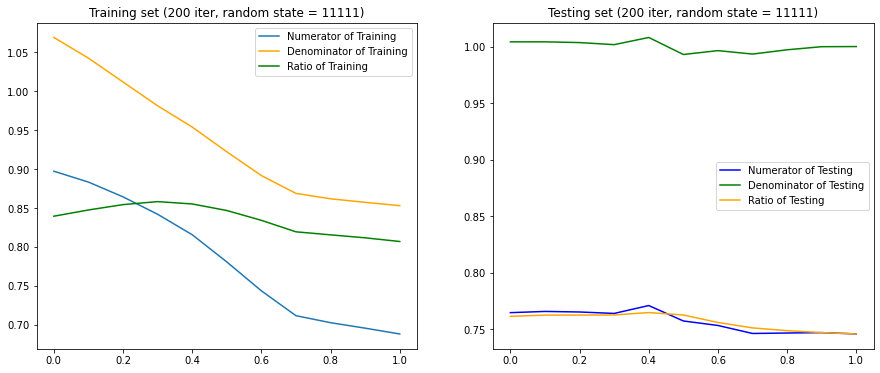

In [24]:
loss = np.arange(0, 1.1, 0.1)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 6))

#loss = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
ax1.plot (loss, num_lst_train, label = "Numerator of Training")

ax1.plot (loss, den_lst_train, label = "Denominator of Training", color = "orange")

ax1.plot (loss, ratio_lst_train, label = "Ratio of Training", color = "green")
ax1.legend()
ax1.set_title ("Training set (200 iter, random state = 11111)")

ax2.plot (loss, num_lst_test, label = "Numerator of Testing", color = "blue")

ax2.plot (loss, den_lst_test, label = "Denominator of Testing", color = "green")

ax2.plot (loss, ratio_lst_test, label = "Ratio of Testing", color = "orange")
ax2.legend()
ax2.set_title ("Testing set (200 iter, random state = 11111)")
fig.show()

<ipython-input-25-0e16dd718f31>:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


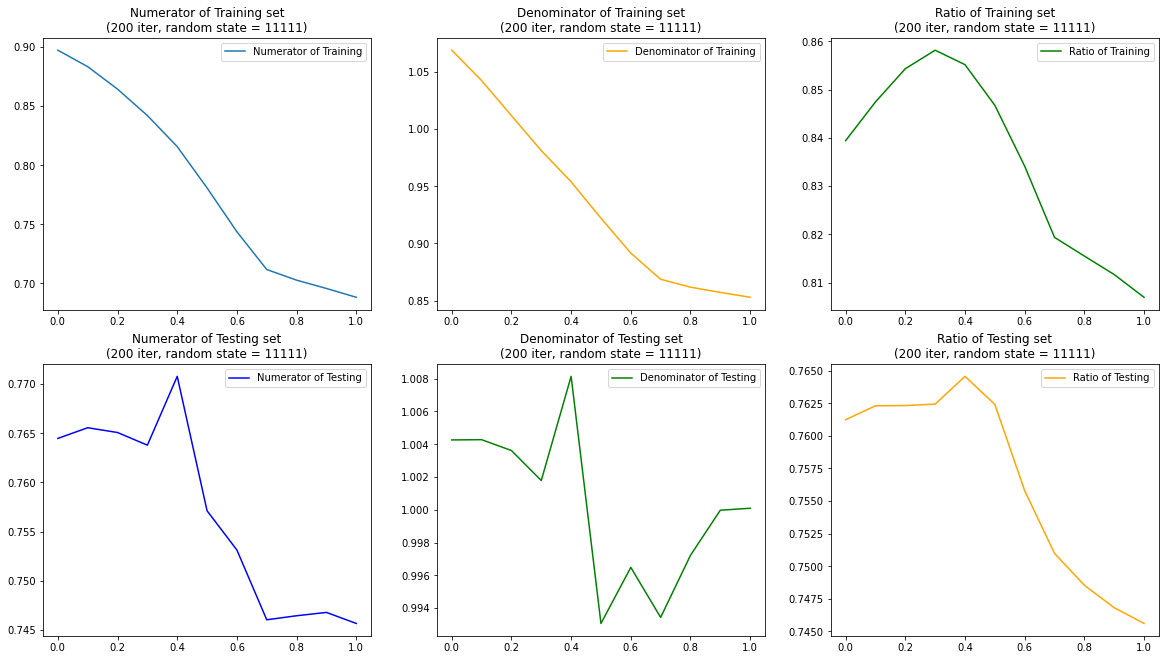

In [25]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3,figsize=(20, 11))

ax1.plot (loss, num_lst_train, label = "Numerator of Training")
ax1.legend()
ax1.set_title ("Numerator of Training set\n(200 iter, random state = 11111)")

ax2.plot (loss, den_lst_train, label = "Denominator of Training", color = "orange")
ax2.legend()
ax2.set_title ("Denominator of Training set\n(200 iter, random state = 11111)")

ax3.plot (loss, ratio_lst_train, label = "Ratio of Training", color = "green")
ax3.legend()
ax3.set_title ("Ratio of Training set\n(200 iter, random state = 11111)")

ax4.plot (loss, num_lst_test, label = "Numerator of Testing", color = "blue")
ax4.legend()
ax4.set_title ("Numerator of Testing set\n(200 iter, random state = 11111)")

ax5.plot (loss, den_lst_test, label = "Denominator of Testing", color = "green")
ax5.legend()
ax5.set_title ("Denominator of Testing set\n(200 iter, random state = 11111)")

ax6.plot (loss, ratio_lst_test, label = "Ratio of Testing", color = "orange")
ax6.legend()
ax6.set_title ("Ratio of Testing set\n(200 iter, random state = 11111)")
fig.show()

In [ ]:
# define NNPolicyLearner with IPW as its objective function
# maximum iterations = 200 and random state = 54321

num_lst_test = []
den_lst_test = []
ratio_lst_test = []
num_lst_train = []
den_lst_train = []
ratio_lst_train = []

def graph_values (pred_actions, action, pscore, rewards):
        idx_tensor = torch.arange(action.shape[0], dtype=torch.long)
        iw = pred_actions[idx_tensor, action] / pscore
        num = np.mean(iw * rewards)
        den = np.mean(iw)
        ratio = num/den
        return num, den, ratio

for l in np.arange(0,1.1,0.1): 
    nn_ipw = NNPolicyLearner(
        n_actions=dataset.n_actions,
        dim_context=dataset.dim_context,
        off_policy_objective="ipw",
        batch_size=64,
        max_iter = 200,
        random_state=54321,
        loss_translation = l
    )

    # train NNPolicyLearner on the training set of logged bandit data
    nn_ipw.fit(
        context=bandit_feedback_train["context"],
        action=bandit_feedback_train["action"],
        reward=bandit_feedback_train["reward"],
        pscore=bandit_feedback_train["pscore"],
    )

    # obtains action choice probabilities for the test set
    action_dist_nn_ipw_test = nn_ipw.predict_proba(
        context=bandit_feedback_test["context"]
    )

    pred_actions_test = action_dist_nn_ipw_test [:,:,0]
    action_test = bandit_feedback_test["action"]
    pscore_test = bandit_feedback_test["pscore"]
    rewards_test = bandit_feedback_test["reward"]

    num_test, den_test, ratio_test = graph_values (pred_actions_test, action_test, pscore_test, rewards_test)
    num_lst_test.append(num_test)
    den_lst_test.append(den_test)
    ratio_lst_test.append(ratio_test)
    print(num_test, den_test, ratio_test)

    action_dist_nn_ipw_train = nn_ipw.predict_proba(
        context=bandit_feedback_train["context"]
    )

    pred_actions_train = action_dist_nn_ipw_train [:,:,0]
    action_train = bandit_feedback_train["action"]
    pscore_train = bandit_feedback_train["pscore"]
    rewards_train = bandit_feedback_train["reward"]

    num_train, den_train, ratio_train = graph_values (pred_actions_train, action_train, pscore_train, rewards_train)
    num_lst_train.append(num_train)
    den_lst_train.append(den_train)
    ratio_lst_train.append(ratio_train)

policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.746036363392997 0.9883638622200722 0.7548195476484166
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7566559715976775 0.9876781397737788 0.7660956956797531
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.756058135289585 0.9863964934166936 0.7664850192955781
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.758643346654915 0.9885420285668856 0.7674366134485343
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7608324037214981 0.9902112460468998 0.7683536283382733
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7597229693271184 0.986812079676872 0.769876033110465
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7647071581849311 0.9931235432979091 0.7700020439003332
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7682606290404402 0.9988703916188377 0.7691294441067018
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7679169713641332 1.0009353930615874 0.767199338426115
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7645777332681015 0.9986027810119275 0.7656475105079537
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning: 100%|██████████| 200/200 [01:08<00:00,  2.92it/s]

0.7399975507484976 0.9748438925774581 0.7590933854978218


<ipython-input-79-0628269e3a9c>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


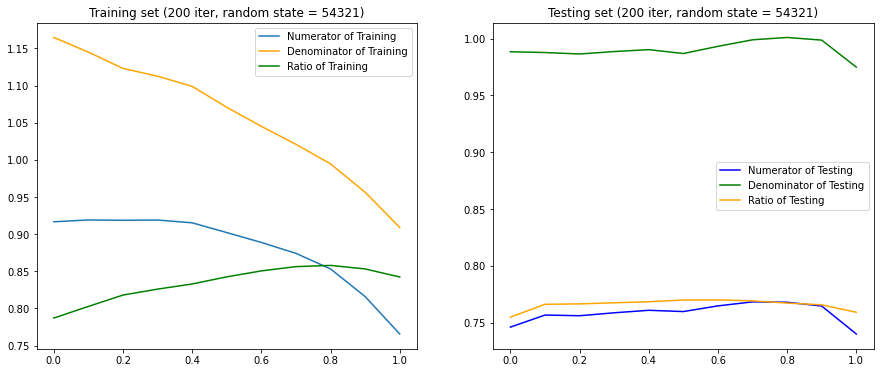

In [ ]:
loss = np.arange(0, 1.1, 0.1)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 6))

#loss = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
ax1.plot (loss, num_lst_train, label = "Numerator of Training")

ax1.plot (loss, den_lst_train, label = "Denominator of Training", color = "orange")

ax1.plot (loss, ratio_lst_train, label = "Ratio of Training", color = "green")
ax1.legend()
ax1.set_title ("Training set (200 iter, random state = 54321)")

ax2.plot (loss, num_lst_test, label = "Numerator of Testing", color = "blue")

ax2.plot (loss, den_lst_test, label = "Denominator of Testing", color = "green")

ax2.plot (loss, ratio_lst_test, label = "Ratio of Testing", color = "orange")
ax2.legend()
ax2.set_title ("Testing set (200 iter, random state = 54321)")
fig.show()

<ipython-input-80-fce1d6354bb1>:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 1080x864 with 0 Axes>

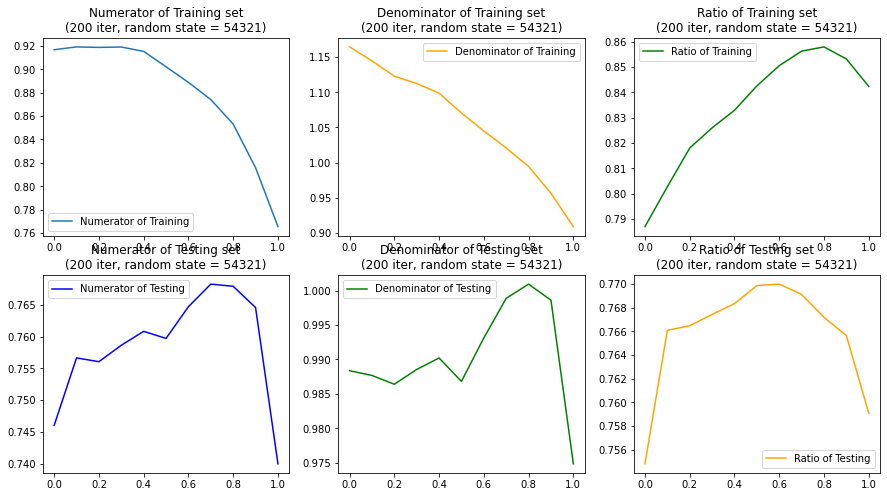

<Figure size 1080x432 with 0 Axes>

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3,figsize=(20, 11))

ax1.plot (loss, num_lst_train, label = "Numerator of Training")
ax1.legend()
ax1.set_title ("Numerator of Training set\n(200 iter, random state = 54321)")

ax2.plot (loss, den_lst_train, label = "Denominator of Training", color = "orange")
ax2.legend()
ax2.set_title ("Denominator of Training set\n(200 iter, random state = 54321)")

ax3.plot (loss, ratio_lst_train, label = "Ratio of Training", color = "green")
ax3.legend()
ax3.set_title ("Ratio of Training set\n(200 iter, random state = 54321)")

ax4.plot (loss, num_lst_test, label = "Numerator of Testing", color = "blue")
ax4.legend()
ax4.set_title ("Numerator of Testing set\n(200 iter, random state = 54321)")

ax5.plot (loss, den_lst_test, label = "Denominator of Testing", color = "green")
ax5.legend()
ax5.set_title ("Denominator of Testing set\n(200 iter, random state = 54321)")

ax6.plot (loss, ratio_lst_test, label = "Ratio of Testing", color = "orange")
ax6.legend()
ax6.set_title ("Ratio of Testing set\n(200 iter, random state = 54321)")
fig.show()

In [ ]:
# # define NNPolicyLearner with DR as its objective function
# nn_dr = NNPolicyLearner(
#     n_actions=dataset.n_actions,
#     dim_context=dataset.dim_context,
#     off_policy_objective="dr",
#     batch_size=64,
#     random_state=12345,
# )

# # train NNPolicyLearner on the training set of logged bandit data
# nn_dr.fit(
#     context=bandit_feedback_train["context"],
#     action=bandit_feedback_train["action"],
#     reward=bandit_feedback_train["reward"],
#     pscore=bandit_feedback_train["pscore"],
# )

# # obtains action choice probabilities for the test set
# action_dist_nn_dr = nn_dr.predict_proba(
#     context=bandit_feedback_test["context"]
# )

In [ ]:
# # define IPWLearner with Logistic Regression as its base ML model
# ipw_lr = IPWLearner(
#     n_actions=dataset.n_actions,
#     base_classifier=LogisticRegression(C=100, random_state=12345)
# )

# # train IPWLearner on the training set of logged bandit data
# ipw_lr.fit(
#     context=bandit_feedback_train["context"],
#     action=bandit_feedback_train["action"],
#     reward=bandit_feedback_train["reward"],
#     pscore=bandit_feedback_train["pscore"]
# )

# # obtains action choice probabilities for the test set
# action_dist_ipw_lr = ipw_lr.predict(
#     context=bandit_feedback_test["context"]
# )

In [ ]:
# # define IPWLearner with Random Forest as its base ML model
# ipw_rf = IPWLearner(
#     n_actions=dataset.n_actions,
#     base_classifier=RandomForest(
#         n_estimators=30, min_samples_leaf=10, random_state=12345
#     )
# )

# # train IPWLearner on the training set of logged bandit data
# ipw_rf.fit(
#     context=bandit_feedback_train["context"],
#     action=bandit_feedback_train["action"],
#     reward=bandit_feedback_train["reward"],
#     pscore=bandit_feedback_train["pscore"],
#     l = 0
# )

# # obtains action choice probabilities for the test set
# action_dist_ipw_rf = ipw_rf.predict(
#     context=bandit_feedback_test["context"]
# )

In [ ]:
# # define Uniform Random Policy as a baseline evaluation policy
# random = Random(n_actions=dataset.n_actions,)

# # compute the action choice probabilities for the test set
# action_dist_random = random.compute_batch_action_dist(
#     n_rounds=bandit_feedback_test["n_rounds"]
# )

In [ ]:
# action_dist is a probability distribution over actions (can be deterministic)
# action_dist_ipw_lr[:, :, 0]

## (3) Evaluation of Off-Policy Learners
Our final step is the evaluation and comparison of the off-policy learners.

With synthetic data, we can calculate the policy value of the off-policy learners as follows. 

$$V(\pi_e) \approx \frac{1}{|\mathcal{D}_{te}|} \sum_{i=1}^{|\mathcal{D}_{te}|} \mathbb{E}_{a \sim \pi_e(a|x_i)} [q(x_i, a)], \; \, where \; \, q(x,a) := \mathbb{E}_{r \sim p(r|x,a)} [r]$$

where $\mathcal{D}_{te}$ is the test set of logged bandit data.

In [ ]:
# # we calculate the policy values of the trained policies based on the expected rewards of the test data
# policy_names = [
#     "NN Policy Learner with DM",
#     "NN Policy Learner with IPW",
#     "NN Policy Learner with DR",
#     "IPW Learner with Logistic Regression",
#     "IPW Learner with Random Forest",
#     "Unifrom Random"
# ]
# action_dist_list = [
#     action_dist_nn_dm,
#     action_dist_nn_ipw,
#     action_dist_nn_dr,
#     action_dist_ipw_lr,
#     action_dist_ipw_rf,
#     action_dist_random
# ]

# for name, action_dist in zip(policy_names, action_dist_list):
#     true_policy_value = dataset.calc_ground_truth_policy_value(
#         expected_reward=bandit_feedback_test["expected_reward"],
#         action_dist=action_dist,
#     )
#     print(f'policy value of {name}: {true_policy_value}')

In fact, `IPWLearner` with `LogisticRegression` seems to be the best in this simple setting.

We can iterate the above process several times to get more reliable results.

Please see [../examples/opl](../opl) for a more sophisticated example of the evaluation of off-policy learners with synthetic bandit data.